In [7]:
### GENERAL REQUIREMENTS - will install the libraries

import pandas as pd
import numpy as np
import math
import nltk
import requests
import re
import json
import io
import time # to avoid errors, we sometime use time.sleep(N) before retrying a request
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

import geopandas
from shapely.geometry import Point
from functools import partial
from shapely.ops import transform
import pyproj

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
from matplotlib.patches import Patch
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from gensim import corpora

import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe
from google.oauth2 import service_account # based on google-auth library

import sddk



In [586]:
# to access gsheet, you need Google Service Account key json file
# I have mine located in my personal space on sciencedata.dk, so I read it from there:
conf = sddk.configure()

# (1) read the file and parse its content
file_data = conf[0].get(conf[1] + "ServiceAccountsKey.json").json()
# (2) transform the content into crendentials object
credentials = service_account.Credentials.from_service_account_info(file_data)
# (3) specify your usage of the credentials
scoped_credentials = credentials.with_scopes(['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive'])
# (4) use the constrained credentials for authentication of gspread package
gc = gspread.Client(auth=scoped_credentials)
# (5) establish connection with spreadsheets specified by their url
occupations = gc.open_by_url("https://docs.google.com/spreadsheets/d/1nONTEwp42CVnq3iCiONrFbJedIcYtBV-l4Bil5mU7Eo/edit?usp=sharing")

sciencedata.dk username (format '123456@au.dk'): 648597@au.dk
sciencedata.dk password: ········
endpoint variable has been configured to: https://sciencedata.dk/files/


In [2]:
conf = sddk.configure("SDAM_root", "648597@au.dk")

sciencedata.dk username (format '123456@au.dk'): 648597@au.dk
sciencedata.dk password: ········
connection with shared folder established with you as its owner
endpoint variable has been configured to: https://sciencedata.dk/files/SDAM_root/


In [21]:
# read the datasets
publicfolder = "e0f9cd400dd05584fe06fe1d804deff0"
EDH = sddk.read_file("EDH_occupsorgs_2021-02-26.json", "df", publicfolder)
EDCS = sddk.read_file("EDCS_occupsorgs_2021-02-26.json", "df", publicfolder)

reading file located in a public folder
reading file located in a public folder


In [211]:
# EDH as a geodataframe
EDHg = EDH[EDH["coordinates"].apply(lambda x: isinstance(x, list))]
EDHg = geopandas.GeoDataFrame(EDHg, geometry=geopandas.points_from_xy(EDHg["coordinates"].apply(lambda x: x[0]), EDHg["coordinates"].apply(lambda x: x[1])), crs={"init": "epsg:3857"})

In [3]:
# read hanson's cities
cities_pop = sddk.read_file("SDAM_data/urban/roman_cities.json", "df", conf)

In [5]:
cities_pop.head(5)

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Longitude (X),...,Select Bibliography,Area,Estimate Basis,Civic Status,Structure,num_of_structures,ID,pop_sample,pop_est,pop_diff
0,Hanson2016_1,Abae,Kalapodi,Achaea,Greece,4 or 5,55 D3,-600,NaN,22.933333,...,BNP; Hansen 2006; Hansen and Nielsen 2004; PEC...,16.0,Walls,[Rights and privileges],"[Acropolis, Agora, Temple of Apollo, Theatre, ...",5,1,NaN,1700.0,NaN
1,Hanson2016_2,Acharnae,Acharnes,Achaea,Greece,3,59 B2,-600,NaN,23.734088,...,BNP; DGRG; PECS; Sear 2006.,NaN,None,None,"[Sanctuary of Apollo Argyieus, Sanctuary of He...",3,2,NaN,1000.0,NaN
2,Hanson2016_3,Acraephia,Akraifnio,Achaea,Greece,3,55 E4,-600,NaN,23.219702,...,BNP; DGRG; Hansen and Nielsen 2004; PECS; Sear...,NaN,None,None,"[Acropolis, Agora, Fountain, Temple of Apollo ...",7,3,NaN,1000.0,NaN
3,Hanson2016_4,Aegina,Aigina,Achaea,Greece,2,59 A3,-600,NaN,23.428500,...,BNP; DGRG; Hansen 2006; Hansen and Nielsen 200...,52.0,Inhabited area,[Rights and privileges],"[Shrine of Aeacus, Stadium, Temple of Aphrodit...",8,4,NaN,8209.0,NaN
4,Hanson2016_5,Aegira,Aigeira,Achaea,Greece,3,58 C1,-600,NaN,22.355720,...,DGRG; Hansen and Nielsen 2004.,NaN,None,None,"[Acropolis, Agora, Gymnasium, Temple of Aphrod...",8,5,NaN,1000.0,NaN


In [6]:
cities_pop.columns

Index(['Primary Key', 'Ancient Toponym', 'Modern Toponym', 'Province',
       'Country', 'Barrington Atlas Rank', 'Barrington Atlas Reference',
       'Start Date', 'End Date', 'Longitude (X)', 'Latitude (Y)',
       'Select Bibliography', 'Area', 'Estimate Basis', 'Civic Status',
       'Structure', 'num_of_structures', 'ID', 'pop_sample', 'pop_est',
       'pop_diff'],
      dtype='object')

In [237]:
cities_pop = geopandas.GeoDataFrame(cities_pop, geometry=geopandas.points_from_xy(cities_pop["Longitude (X)"], cities_pop["Latitude (Y)"]), crs={"init":"epsg:3857"})

In [213]:
### # pelagios provinces - only for plotting purposes
url = "https://raw.githubusercontent.com/pelagios/magis-pleiades-regions/main/pleiades-regions-magis-pelagios.geojson"
pleiades_regions = geopandas.read_file(url, crs={"init": "epsg:3857"})
pleiades_regions.head()

,name,uri,geometry
0,Lusitania,http://pleiades.stoa.org/places/1101,"POLYGON ((-7.31057 37.19663, -7.32457 37.19556..."
1,Byzacena,http://pleiades.stoa.org/places/991345,"MULTIPOLYGON (((11.01815 34.62424, 11.00879 34..."
2,Viennensis,http://pleiades.stoa.org/places/992074,"POLYGON ((4.62344 45.60642, 4.71224 45.60876, ..."
3,Lycia et Pamphylia,http://pleiades.stoa.org/places/981530,"MULTIPOLYGON (((29.62331 36.07470, 29.61295 36..."
4,Savia,http://pleiades.stoa.org/places/991357,"POLYGON ((18.10598 45.77203, 18.10654 45.71079..."


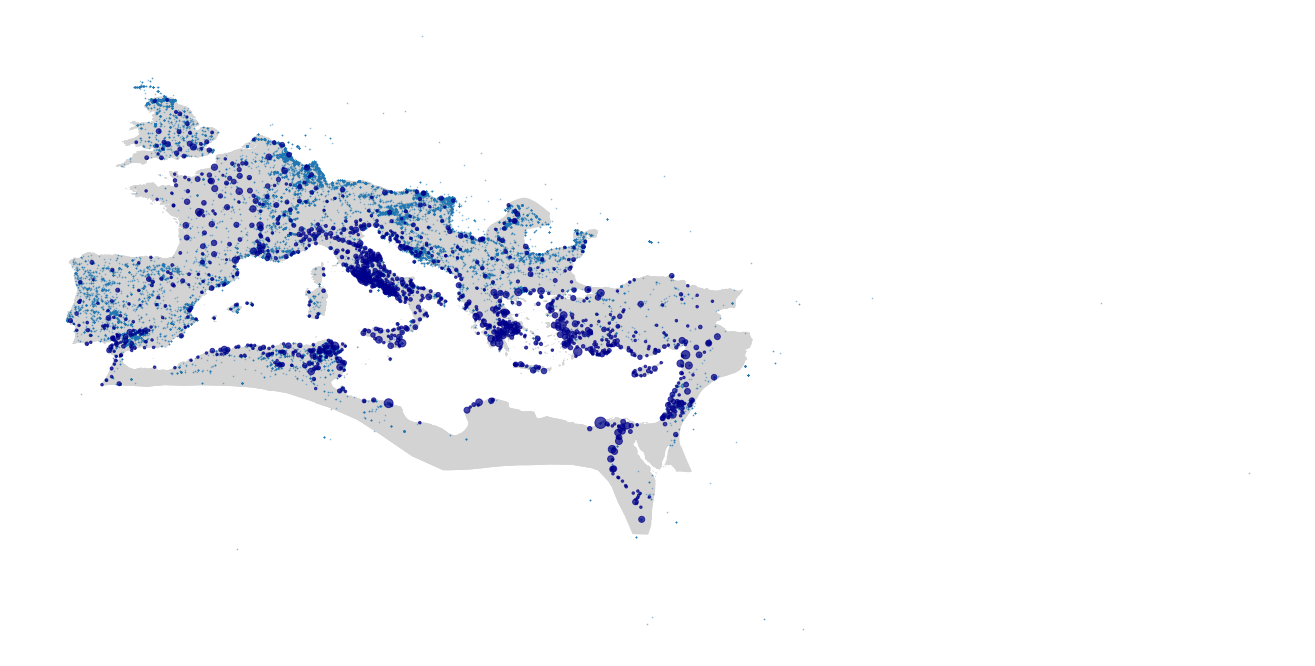

In [214]:
fig, ax = plt.subplots(figsize=[24, 12])
pleiades_regions.plot(ax=ax, color="lightgray")
EDHg.plot(ax=ax, alpha=0.4, markersize=0.5)
cities_pop.plot(markersize=np.sqrt(cities_pop["pop_est"]) / 5, color="darkblue", alpha=0.7, ax=ax)
ax.set_axis_off()

In [215]:
cities_pop.sort_values("pop_est", ascending=False, inplace=True)

In [216]:
len(cities_pop)

1388

In [217]:
# total urban population
cities_pop["pop_est"].sum()

10159670.0

In [218]:
# size of urban population living within 50 biggest cities
cities_pop["pop_est"][:50].sum()

4059005.0

In [663]:
cities_pop.columns

Index(['Primary Key', 'Ancient Toponym', 'Modern Toponym', 'Province',
       'Country', 'Barrington Atlas Rank', 'Barrington Atlas Reference',
       'Start Date', 'End Date', 'Longitude (X)', 'Latitude (Y)',
       'Select Bibliography', 'Area', 'Estimate Basis', 'Civic Status',
       'Structure', 'num_of_structures', 'ID', 'pop_sample', 'pop_est',
       'pop_diff', 'geometry'],
      dtype='object')

In [712]:
# create two groups of cities
cities_big = cities_pop[cities_pop["pop_est"] >= 30000]
cities_rest = cities_pop[(cities_pop["pop_est"] < 30000) & (cities_pop["pop_est"] > 1000)]
print("big cities (n={2}) - pop {0}, middle cities (n={3}) {1}".format(cities_big["pop_est"].sum(), cities_rest["pop_est"].sum(), len(cities_big), len(cities_rest)))

big cities (n=68) - pop 4641352.0, middle cities (n=690) 4942985.0


In [674]:
# by default, buffer is calculated in degrees
# we need to reproject it to calculate buffer in meters

def buffer_in_meters(lng, lat, area_ha, coef):
    proj_meters = pyproj.Proj(init='epsg:3857')
    proj_latlng = pyproj.Proj(init='epsg:4326')
    
    project_to_meters = partial(pyproj.transform, proj_latlng, proj_meters)
    project_to_latlng = partial(pyproj.transform, proj_meters, proj_latlng)
    
    pt_latlng = Point(lng, lat)
    pt_meters = transform(project_to_meters, pt_latlng)
    try:
        radius = coef # to include area radius: np.sqrt((area_ha * 10000) / np.pi) +
        buffer_meters = pt_meters.buffer(radius)
    except:
        radius = coef
        buffer_meters = pt_meters.buffer(radius)
    buffer_latlng = transform(project_to_latlng, buffer_meters)
    return buffer_latlng

In [675]:
# makes the buffer the main geometry
cities_big["geometry"] = cities_pop.apply(lambda row: buffer_in_meters(row["Longitude (X)"], row["Latitude (Y)"], row["Area"], 37000), axis=1)
cities_rest["geometry"] = cities_pop.apply(lambda row: buffer_in_meters(row["Longitude (X)"], row["Latitude (Y)"], row["Area"], 18500), axis=1)

<AxesSubplot:>

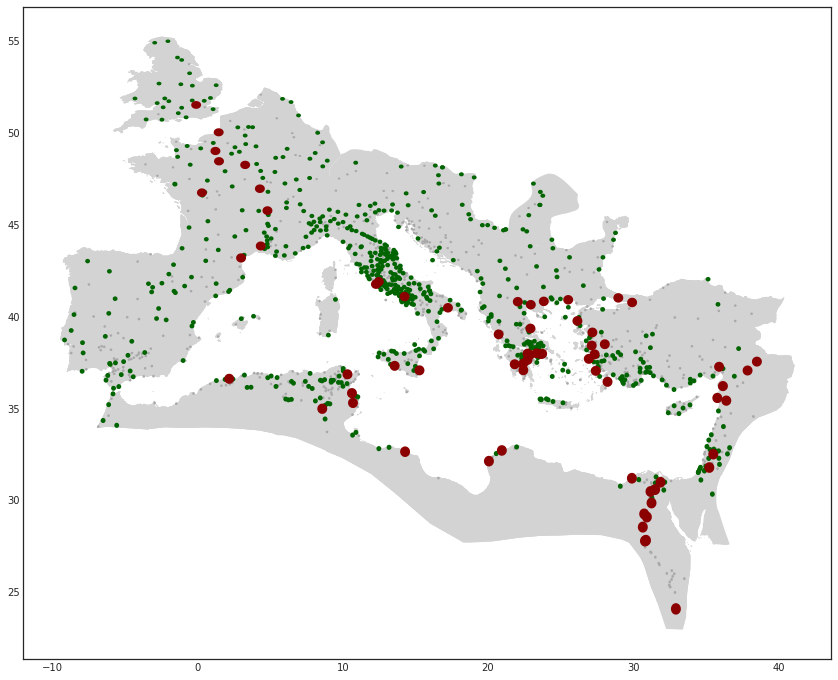

In [678]:
fig, ax = plt.subplots(figsize=[24, 12])
pleiades_regions.plot(ax=ax, color="lightgray")
cities_pop.plot(ax=ax, color="darkgrey")
cities_rest.plot(ax=ax, color="darkgreen")
cities_big.plot(ax=ax, color="darkred")
#ax.set_axes_off()
#EDHg.plot(ax=ax, alpha=0.4, markersize=0.5)

In [82]:
### some inspiration from here
# https://gis.stackexchange.com/questions/349637/given-list-of-points-lat-long-how-to-find-all-points-within-radius-of-a-give

In [679]:
cities_big_multipolygon = cities_big["geometry"].unary_union
cities_rest_multipolygon = cities_rest["geometry"].unary_union

In [680]:
# inscriptions within the radius of big cities
EDHg_big_cities = EDHg[EDHg.within(cities_big_multipolygon)]
len(EDHg_big_cities)

10023

In [681]:
# extract ids of matched inscriptions (to be excluded from the subsequent matches)
big_ids = EDHg_big_cities["id"].tolist() # for filtering

In [682]:
EDHg_rest_cities = EDHg[EDHg.within(cities_rest_multipolygon)]
EDHg_rest_cities = EDHg_rest_cities[~EDHg_rest_cities["id"].isin(big_ids)]  # ) & (not EDHg.within(cities_small_multipolygon))]


In [683]:
len(EDHg_rest_cities)

32601

In [684]:
bigmiddle_ids = big_ids + EDHg_rest_cities["id"].tolist() # for filtering
len(bigmiddle_ids)

42624

In [685]:
EDHg_rural = EDHg[~EDHg["id"].isin(bigmiddle_ids)]
len(EDHg_rural)

36388

In [686]:
EDHg_big_cities["occups_N"].sum() / len(EDHg_big_cities), EDHg_rest_cities["occups_N"].sum() / len(EDHg_rest_cities), EDHg_rural["occups_N"].sum() / len(EDHg_rural)

(0.054973560810136685, 0.031103340388331645, 0.0176156974826866)

# Bootstrap test

Brezina 2018, p. 232, drawing on Lijffijt 2016
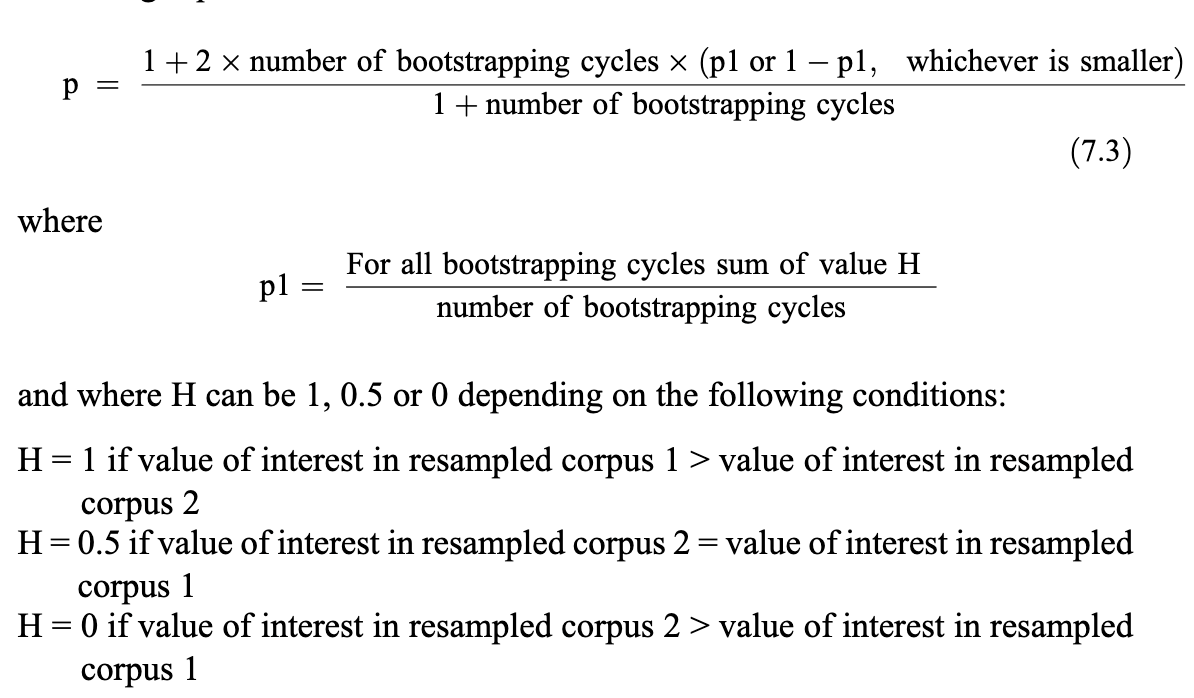

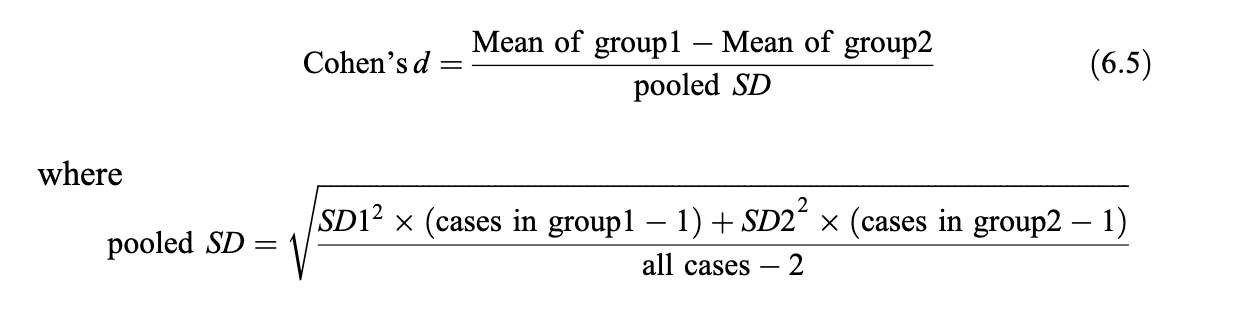

In [698]:
def get_bootstrap(df, n_of_bootstraps, bootstrap_size, column, row_function=None):
    bootstrap_values = []
    for n in range(n_of_bootstraps):
        sample_df = df.sample(bootstrap_size, replace=True)
        if row_function == None:
            bootstrap_values.append(sample_df[column].sum())
        else:
            bootstrap_values.append(sample_df[column].apply(row_function).mean())
    return bootstrap_values

def get_statistics(df1, df2, n_of_bootstraps, bootstrap_size, column, row_function=None):
    bootstrap_test_values = []
    df1_values = get_bootstrap(df1, n_of_bootstraps, bootstrap_size, column, row_function)
    df2_values = get_bootstrap(df2, n_of_bootstraps, bootstrap_size, column, row_function)
    # H values
    H_list = []
    for n in range(n_of_bootstraps):
        if df1_values[n] == df2_values[n]:
            H_list.append(0.5)
        else:
            if df1_values[n] > df2_values[n]:
                H_list.append(1)
            else:
                H_list.append(0)
    # CONFIDENCE INTERVAL (950) for the difference
    difference = np.array(df1_values) - np.array(df2_values)
    CI95 = (np.percentile(difference, 2.5), np.percentile(difference, 97.5))
    # COHENS DELTA
    pooled_sd = np.sqrt(((len(df1_values) - 1) * ((np.std(df1_values)**2))) + ((len(df2_values) - 1) * (np.std(df2_values)**2)) / (len(df1_values) + len(df2_values) + 2))
    cohens_delta = (np.mean(df1_values) - np.mean(df2_values)) / pooled_sd
    return H_list, cohens_delta, CI95, [df1_values, df2_values]

def bootstrap_test(df1, df2, n_of_bootstraps, bootstrap_size, column, row_function=None):
    H_values, cohens_delta, CI95, data = get_statistics(df1, df2, 1000, 1000, "occups_N", row_function)
    p1 =  sum(H_values) / len(H_values)
    p = (1 + (2 * len(H_values) * np.min((p1, 1 - p1)))) / (1 + len(H_values))
    return p, cohens_delta, CI95, data

In [688]:
# test1 "get_bootstrap()"
df1_values = get_bootstrap(EDHg_big_cities, 1000, 1000, "occups_N")
df2_values = get_bootstrap(EDHg_rest_cities, 1000, 1000, "occups_N")

print(df1_values[:10])
print(df2_values[:10])

[0.046, 0.057, 0.041, 0.05, 0.065, 0.065, 0.053, 0.062, 0.06, 0.059]
[0.025, 0.027, 0.027, 0.034, 0.027, 0.042, 0.035, 0.027, 0.026, 0.044]


In [689]:
# test3 "get_H_values"
H_list = get_H_values(EDHg_big_cities, EDHg_rest_cities, 1000, 1000, "occups_N")

In [699]:
p, cohens_d, CI95, data_occups_urban_rest = bootstrap_test(EDHg_big_cities, EDHg_rest_cities, 1000, 1000, "occups_N")
p, cohens_d, CI95

(0.023976023976023882, 0.07735523193444965, (3.0, 47.0))

In [700]:
p, cohens_d, CI95, data_occups_rest_rural = bootstrap_test(EDHg_rest_cities, EDHg_rural, 1000, 1000, "occups_N")
p, cohens_d, CI95

(0.12987012987012986, 0.06614243125278971, (-4.0, 30.0))

In [701]:
p, cohens_d, CI95, data_orgs_urban_rest = bootstrap_test(EDHg_big_cities, EDHg_rest_cities, 1000, 1000, "organizations_N")
p, cohens_d, CI95

(0.030969030969030996, 0.07886559466154285, (2.0, 46.0))

In [702]:
p, cohens_d, CI95, data_orgs_rest_rural = bootstrap_test(EDHg_rest_cities, EDHg_rural, 1000, 1000, "organizations_N")
p, cohens_d, CI95

(0.090909090909091, 0.06818905039174986, (-2.0249999999999986, 30.0))

Text(0, 0.5, 'Number of organizations\nper 1,000 inscriptions')

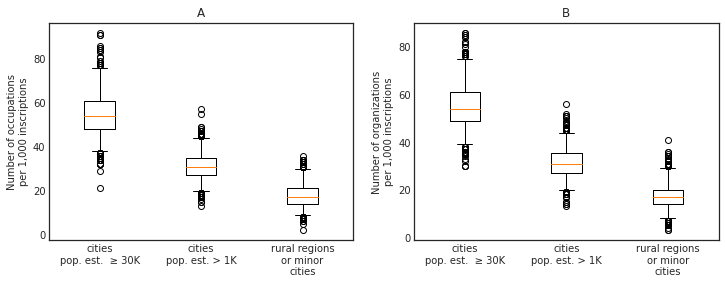

In [703]:
plt.style.use("seaborn-white")

labels=[
    "cities\npop. est.  ≥ 30K",
    "cities\npop. est. > 1K",
    "rural regions\nor minor\ncities"
]

fig, [ax1, ax2] = plt.subplots(1,2, figsize=[12,4])
ax1.boxplot(data_occups_urban_rest + [data_occups_rest_rural[1]], whis=[2.5, 97.5], labels=labels)
ax1.set_title("A")
ax1.set_ylabel("Number of occupations\nper 1,000 inscriptions")

ax2.boxplot(data_orgs_urban_rest + [data_orgs_rest_rural[1]], whis=[2.5, 97.5], labels=labels)
ax2.set_title("B")
ax2.set_ylabel("Number of organizations\nper 1,000 inscriptions")

# By industry type

In [704]:
occupations_df = get_as_dataframe(occupations.worksheet("Occupation"))
occupations_df = occupations_df[['Term', 'gen_sg', 'Vocab_nom_sg', 'Source', 'Category', 'Subcategory','Translation_eng']]
occupations_df = occupations_df.dropna(thresh=5)
occups_cats_dict = dict(zip(occupations_df["Term"], occupations_df["Category"]))

In [705]:
def cat_for_occup(list_of_occups):
    try:
        return [occups_cats_dict[occup] for occup in list_of_occups]
    except:
        return []
    
EDHg_big_cities["occups_cats"] = EDHg_big_cities["occups"].apply(cat_for_occup)
EDHg_rest_cities["occups_cats"] = EDHg_rest_cities["occups"].apply(cat_for_occup)
EDHg_rural["occups_cats"] = EDHg_rural["occups"].apply(cat_for_occup)

In [706]:
wordcount = EDHg_big_cities["clean_text_interpretive_word"].apply(lambda x: len(x.split())).sum()

In [707]:
occups_cats_data = {}

labels=[
    "cities\npop. est.  ≥ 30K",
    "cities\npop. est. > 1K",
    "rural regions\nor minor\ncities"
]
all_present_categories = []

for df_subset, subset_title in zip([EDHg_big_cities, EDHg_rest_cities, EDHg_rural], labels):
    occups_cats_list = [el for sublist in df_subset["occups_cats"].tolist() for el in sublist]
    wordcount = df_subset["clean_text_interpretive_word"].astype("str").apply(lambda x: len(x.split())).sum()
    occups_cats_dist = nltk.FreqDist(occups_cats_list).most_common()
    categories = [tup[0] for tup in occups_cats_dist]
    all_present_categories.extend(categories[:10])
    freqs = [(tup[1] / wordcount) * 10000 for tup in occups_cats_dist]
    cat_freq_dict = dict(zip(categories[:10], freqs[:10]))
    total_freq = np.sum(freqs)
    occups_cats_data[subset_title] = {"categories" : categories, "freqs" : freqs, "cat_freq_dict" : cat_freq_dict,"total_freq" : total_freq}
    print(categories, freqs, total_freq)
all_present_categories = list(set(all_present_categories))

['Metal-Working', 'Miscellaneous Services', 'Managerial', 'Education', 'Building', 'Transport', 'Clothing', 'Retail', 'Food-Production', 'Performing Arts', 'Plastic Arts', 'Household Goods', 'Finance', 'Food-Retail', 'Fuel / Raw material', 'Glass-Working', 'Water-Management'] [7.89756687726845, 5.937177936102523, 4.144822332750818, 2.296455616794372, 1.9043778285611863, 1.6803333781422234, 1.5123000403280011, 1.4562889277232602, 1.4562889277232602, 0.9521889142805932, 0.5041000134426671, 0.39207778823318545, 0.2800555630237039, 0.2800555630237039, 0.05601111260474078, 0.05601111260474078, 0.05601111260474078] 30.862123045212165
['Metal-Working', 'Miscellaneous Services', 'Managerial', 'Building', 'Retail', 'Performing Arts', 'Education', 'Clothing', 'Food-Production', 'Finance', 'Plastic Arts', 'Transport', 'Food-Retail', 'Household Goods', 'Water-Management', 'Death-care sector', 'Unclear meaning', 'Glass-Working'] [7.9367093572419005, 3.206984304234373, 2.976266008965713, 1.568884407

In [708]:
occups_cats_data

{'cities\npop. est.  ≥ 30K': {'categories': ['Metal-Working',
   'Miscellaneous Services',
   'Managerial',
   'Education',
   'Building',
   'Transport',
   'Clothing',
   'Retail',
   'Food-Production',
   'Performing Arts',
   'Plastic Arts',
   'Household Goods',
   'Finance',
   'Food-Retail',
   'Fuel / Raw material',
   'Glass-Working',
   'Water-Management'],
  'freqs': [7.89756687726845,
   5.937177936102523,
   4.144822332750818,
   2.296455616794372,
   1.9043778285611863,
   1.6803333781422234,
   1.5123000403280011,
   1.4562889277232602,
   1.4562889277232602,
   0.9521889142805932,
   0.5041000134426671,
   0.39207778823318545,
   0.2800555630237039,
   0.2800555630237039,
   0.05601111260474078,
   0.05601111260474078,
   0.05601111260474078],
  'cat_freq_dict': {'Metal-Working': 7.89756687726845,
   'Miscellaneous Services': 5.937177936102523,
   'Managerial': 4.144822332750818,
   'Education': 2.296455616794372,
   'Building': 1.9043778285611863,
   'Transport': 1.680

In [709]:
data_by_category = {}
for cat in all_present_categories:
    cat_data = []
    for label in labels:
        try:
            cat_data.append(occups_cats_data[label]["cat_freq_dict"][cat])
        except:
            cat_data.append(0)
    data_by_category[cat] = cat_data

In [710]:
data_by_category

{'Food-Production': [1.4562889277232602,
  0.8075140334403097,
  0.6534514886046492],
 'Education': [2.296455616794372, 1.0613041582358356, 0.6112933280495105],
 'Finance': [0, 0.4845084200641858, 0],
 'Performing Arts': [0.9521889142805932,
  1.3612379420850935,
  0.7377678097149265],
 'Retail': [1.4562889277232602, 1.4535252601925575, 0.8642422913803426],
 'Clothing': [1.5123000403280011, 0.8998013515477737, 0.3583443647186786],
 'Transport': [1.6803333781422234, 0, 0.4005025252738173],
 'Managerial': [4.144822332750818, 2.976266008965713, 1.538772860262561],
 'Metal-Working': [7.89756687726845, 7.9367093572419005, 4.616318580787683],
 'Miscellaneous Services': [5.937177936102523,
  3.206984304234373,
  2.2133034291447795],
 'Building': [1.9043778285611863, 1.5688844078268875, 0.9696376927681891]}

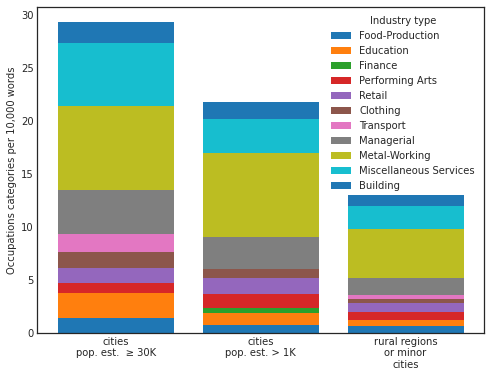

In [711]:
plt.style.use("seaborn-white")

fig, ax = plt.subplots(figsize=[8,6])
first_bar_cat = list(data_by_category.keys())[0]
ax.bar(labels, data_by_category[first_bar_cat], label=first_bar_cat)
bottom = data_by_category[first_bar_cat]
for cat in list(data_by_category.keys())[1:]:
    ax.bar(labels, data_by_category[cat], bottom = bottom, label=cat)
    bottom += np.array(data_by_category[cat])
ax.set_ylabel("Occupations categories per 10,000 words")
ax.legend(title="Industry type", bbox_to_anchor=(1, 1))
